# T2 mapping Lab 2 Work

### optional: for parallel computation

In [1]:
# addprocs(Sys.CPU_CORES-nprocs());
# nprocs()

### Loading juila packages

This cell only needs to run once when you start the kernel & this notebook

**Notes:**
* The "push!" function shown below takes the LOAD_PATH (which is an array of typical file paths containing modules) and appends the "library" path to the array. This allows julia to find the NifTI files (MRI data) in the library folder located in this notebooks directory.
* The "using" is a function that is calling modules (source code that containes functions and variables for this notebook) and compiles them (using the most specific method possible).
* The "Read_NIfTI1_real" and "NK_tools" are in the "library" path that was added. The "PyPlot is a module in Julia's standard library.

In [2]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
using PyPlot
using NK_tools

### Loading NIfTI file

**Notes:**
* Each NifTI file contains a header and image data. the "load_niigz..." functions are frome the loaded modules. the image data array is 4 dimensional; the first three dimensions of the data set are the spatial coordinates for the single intensity point (x, y, z or anatomical slice) while the last dimenstion is indicates a time point (a shot instance for a given set of spatial coordinates). This time point is some key point in the special echo pulse sequence implemented (perhaps the echo time or the time at which the image data was collected).

* "println()" means print and start on new line while "print()" is simply just print the string inside the parentheses. the ".\n" in the parentheses of the print functions means put a new line at this point in the generated text.
* The "type of data" shows that it is an array of where each data point is of four dimensions (the three spatial coordinates and the echotime snapshot info) where each piece of information is a 16 bit integer.

In [3]:
filename = "data/T2data.nii.gz";
headerinfo = load_niigz_header(filename); 
data = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl

println("data size : ", size(data))
print("type of data: ", typeof(data))
print(".\n\n So there is ", size(data)[3], " slices and ")
println(size(data)[4]," shots for each slice.")
print(" Each shot is ", size(data)[1]," by ", size(data)[2], " pixels (x-dim by y-dim).")

data size : (192, 192, 4, 11)
type of data: Array{Int16,4}.

 So there is 4 slices and 11 shots for each slice.
 Each shot is 192 by 192 pixels (x-dim by y-dim).

### Displaying a single slice corresponding a certain TE (echo time)

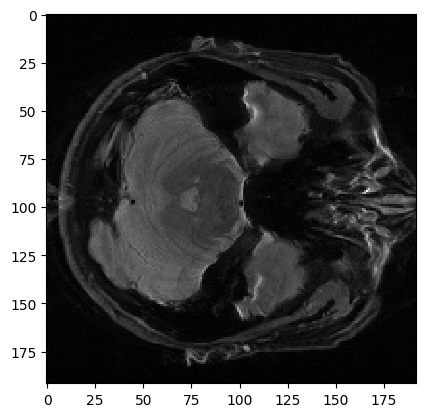

In [4]:
sliceNum = 1 # the slice (along the  z-axis) that want to look at
echoNum = 4 # the snapshot at a specific echotime

imshow(data[:,:,sliceNum, echoNum],cmap="gray", interpolation="none"); # part of PyPlot

### Displaying multiple echoes (an array of snapshots in one figure) for slice #3

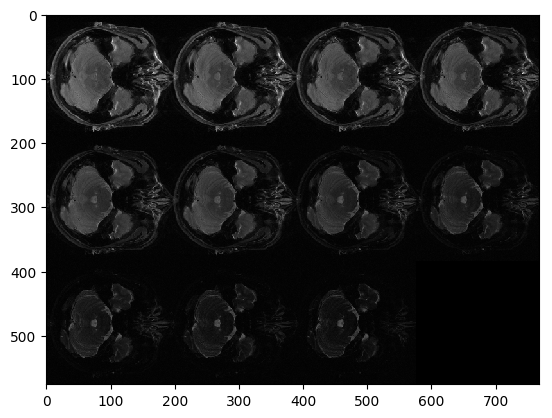

884736

In [5]:
sliceNum = 1; # the slice (along the  z-axis) that want to look at
echoTotNum = 11; # the snapshot instances or echo recordings for a slice want to look at
horiDimenSize = 4; # horizonal dimension of plot (how many images along x-axis)
vertDimenSize = 3; # vertical dimension of plot (how many images along y-axis)
imal(data[:,:,sliceNum,:],horiDimenSize, vertDimenSize); # see the source codes in library/NK_tools.jl

###  Converting data to double float format for further analysis

In [6]:
dataDouble = convert(Array{Float64},data);
println("type of data: ", typeof(dataDouble))

type of data: Array{Float64,4}


### T2 fitting for a single voxel (e.g., dataDouble[51,67,3,:] )

* TE value in T2data: 
    [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];

* TE values in in T2stardata: 
    [10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0]
* Use mricron to select your voxel [https://www.nitrc.org/projects/mricron]


**Notes:**
$$ S = P \exp(-t / T_2)$$

So the fit is linear, we can. . .
 
$$ \log(S) = \log(P) + (-t/T_2)$$

For computation, we now rewrite as. . .

$$ data1D = c[2] + TE  *  c[1]$$

where $$c[1] = 1/T_2$$ and $$ c[2] = \log(P)$$

The first equation charaterizes the natural T_2 decay of a MRI intensity signal within a specific voxel. "P" is the maximum voxel signal immediately after the proton spins have been titled into the anatomical traverse plane (the plane of the horizonal and vertical axis). the logarithm of both sides is taken in order to linearize the fitting process for T_2 (the time for the traverse magnetic moments to decay to 37% of its original sinal strength "P"). TE is the echo time or the time between the transvese spin inducing RF pulse and the "echo" of the spins (the point at which the spins are again rephased due to a initiating of another RF pulse). Doing this fit can provide us an estimate for T_2.

The plot below (x-axis = echo time TE, y-axis = signal strength of spin) displays both the decaying transverse spin instensity ("S" and the blue dots) with its calculated linear fit. Each blue dot represents 1 of the 11 snaptshots of a MRI slice.  

71555.4488603186

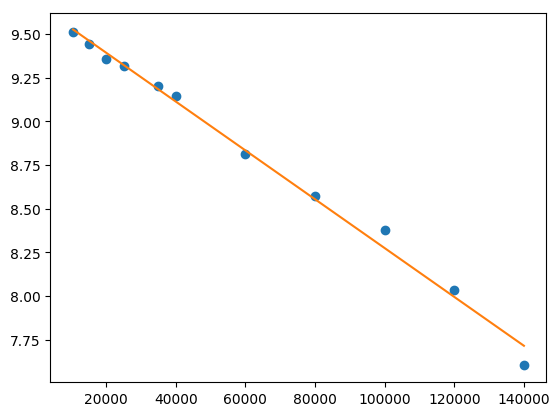

In [7]:
data1D = dataDouble[51,67,3,:];
TEvalue = [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];
#figure(1); plot(TEvalue, data1D)
X = zeros(size(data)[4],2); 
X[:,1] = TEvalue;  X[:,2] = 1.0
coeff = X\log.(data1D)
figure(1); plot(TEvalue, log.(data1D),"o"), plot(TEvalue, coeff[1]*TEvalue + coeff[2]);
display(-1/coeff[1])

### T2 mapping

* TE value in T2data: 
    [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];

* TE values in in T2stardata: 
    [10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0]
    
**Notes:**

This is repeating T_2 fitting but for all voxels. The TE times mentioned above seem to be from the files in the "data" folder.


In [8]:
T2map = zeros(size(data)[1],size(data)[2],size(data)[3]);
# T2map = SharedArray{Float64,3}((size(data)[1],size(data)[2],size(data)[3])); # this is for parallel computation
TEvalue = [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];
X = zeros(size(data)[4],2); 
X[:,1] = TEvalue;  X[:,2] = 1.0
# @sync @parallel for cntz = 1:size(data)[3]
for cntz = 1:size(data)[3]
    for cnty = 1:size(data)[2]
        for cntx = 1:size(data)[1]
            data1D = dataDouble[cntx,cnty,cntz,:];
            coeff = X\log.(data1D)
            T2map[cntx,cnty,cntz]=-1/coeff[1];
        end
    end
end

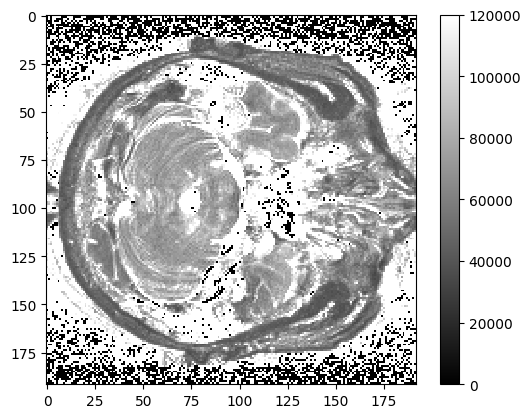

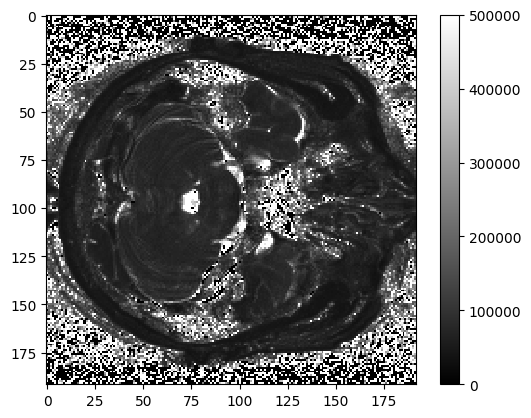

PyObject <matplotlib.colorbar.Colorbar object at 0x000000003378A588>

In [9]:
figure(1); imshow(T2map[:,:,1],vmin=0,vmax=120000,cmap="gray",interpolation="none");colorbar()
figure(2); imshow(T2map[:,:,1],vmin=0,vmax=500000,cmap="gray",interpolation="none");colorbar()

### Saving T2 map to a NIFTI file

In [10]:
T2mapInt = deepcopy(T2map);
L = find(T2mapInt.>1000000);
T2mapInt[L] = 1000000;
L = find(T2mapInt.<0);
T2mapInt[L] = 0;
headerinfo["cal_max"] = Float32(200);
headerinfo["cal_min"] = Float32(0);
headerinfo["datatype"] = Int16(4)
T2mapInt = convert(Array{Int16,3}, round.(T2mapInt/1000))
newFileName = "data/T2mapInt.nii"
headerinfo["dim"][1:5]=[3,size(T2map)[1],size(T2map)[2],size(T2map)[3],1]
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, T2mapInt);
close(fid);

# Homework Answers

### Homework Tasks addressed
* Measure the T2 values of gray-matter, white-matter, and CSF
* Calculate and save proton density maps
* Interpret and simulate MRI signals (0 to 120 msec after a 90-degree RF pulse excitation) based on these equations Robert W. Brown's MRI text book: ![Block equations](data/Bloch_equations.jpeg)

#### Measuring T2 Values

The T2 value of gray-matter, white-matter, and CSF can be approximated for slice 3 based on the following intensity approximations by using imageJ. The maximum possible signal was 1000. Each of the intensity estimates were averages of the measurements located in the text files in the "data" folder.

CSF = 434.0, 
Gray-Matter = 71.488, 
White-Matter = 61.474

Given the echo time for this slice (we only saved the first snapshot corresponding to TE = 10.5 ms), then we can estimate the T2 for these tissue by. . .

$$ S = P \exp(-t / T_2)$$

Which can be rewritten as (letting t = TE). . .

$$ T_2 = TE_1 / \log(P/S)$$

In [11]:
sigArray = 1000./[434.0,71.488,61.474];
T2Array = log.(sigArray);
for i = 1: 3
    T2Array[i]=(10.5)/T2Array[i];
end

print("CSF = ", T2Array[1],", Gray-Matter = ", T2Array[2], ", White-Matter = ", T2Array[3])

CSF = 12.579207904515133, Gray-Matter = 3.979947620617834, White-Matter = 3.7645999821858904

These T2 times are in miliseconds. The times reflect that the CSF has the longest T2 relaxation time, meaning the transverse spins of the CSF take the most time to dephase and are thus indicated with larger pixel intensity in a MRI image. This also means the the CSF has the highest proton density because the long T2 time reflects that the CSF does not have many other non-water molecules to have collisions with its constituent water molecules (such collisions are a big contributor to the dephasing of the transverse spins.)

#### Calculating Proton Density Maps

The proton density maps (MRI images) are saved in the "data" folder as "T2mapInt.nii".

#### Simulating MRI Signals

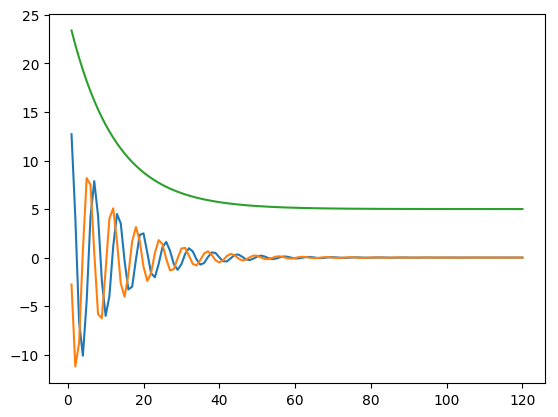

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000037460C88>

In [12]:
function Mx(t, wo::Float64, T2::Float64, Mx0::Float64, My0::Float64)
    exp.(-t/T2)*(Mx0*cos.(wo*t) + My0*sin.(wo*t));
end

function My(t, wo::Float64, T2::Float64, Mx0::Float64, My0::Float64)
    exp.(-t/T2)*(My0*cos.(wo*t) - Mx0*sin.(wo*t));
end

function Mz(t, wo::Float64, T2::Float64, Mz0::Float64, M0::Float64)
    Mz0*exp.(-t/T2) + M0*(1.0 - exp.(-t/T2));
end

t = zeros(120);
for i = 1: 120
    t[i] = Float64(i);
end

wo = 1.0;
T2 = 12.0;
Mx0 = 10.0;
My0 = 10.0;
Mz0 = 25.0;
M0 = 5.0;

figure(1);
plot(t, Mx.(t, wo, T2, Mx0, My0)), plot(t, My.(t, wo, T2, Mx0, My0))
plot(t, Mz.(t, wo, T2, Mz0, M0))

The above plot displays the longitudinal magentization of the proton spins ("Mz" in green), and the transverse magentizations of the proton spins shortly after a 90 degree MRI pulse ("Mx" and "My" in blue and orange respectively). The "Mz" magnetization modals shows that even though the "Mz" magnetization is slowly returning after the 90 degree RF pulse, it is exponentially decaying due to dephasing marked by T2 relaxation. The T2 relaxation phenomenon is in the traverse plane is reflected by the the "Mx" and the "My" magentizations due to the proton spins returning to their original directions along the longitudinal axis. During the dephasing process taking place in the transverse plane (the overall expoenential decline of the "Mx" and "My" transverse magnetizations), there are periodic moments in which the magnetizations are maximally in phase (the sinosudal aspect of the transverse magentizations).